___
# **Importing Libraries and Setting Up Environment**

In [ ]:
import zipfile
import os
import logging
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline

!pip install torch
!pip install optuna
import optuna
import torch
from torch import nn
import torchvision.models as models
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D, Activation, BatchNormalization, AveragePooling2D, Add, ReLU
from keras import Model
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount("/content/drive")

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, f1_score

# Pandas options
pd.set_option("display.max_columns", 500)
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
!mkdir "data"
with zipfile.ZipFile('/content/drive/MyDrive/Data/Wildlife_Image_Classification/train_features.zip', 'r') as zip_ref:
    zip_ref.extractall("data")

!mkdir "data_original"
with zipfile.ZipFile('/content/drive/MyDrive/Data/Wildlife_Image_Classification/train_features_original.zip', 'r') as zip_ref:
    zip_ref.extractall("data_original")

!mkdir "data_test"
with zipfile.ZipFile('/content/drive/MyDrive/Data/Wildlife_Image_Classification/test_features.zip', 'r') as zip_ref:
    zip_ref.extractall("data_test")

In [ ]:
# Universal variables
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
EPOCH = 25
SEED = 42

---
# **Training and Validation Preprocessing**

In [ ]:
# For pytorch Resnet50 model and EDA
train_features = pd.read_csv("/content/drive/MyDrive/Data/Wildlife_Image_Classification/train_features.csv", index_col="id")
test_features = pd.read_csv("/content/drive/MyDrive/Data/Wildlife_Image_Classification/test_features.csv", index_col="id")
train_labels = pd.read_csv("/content/drive/MyDrive/Data/Wildlife_Image_Classification/train_labels.csv", index_col="id")

species_labels = sorted(train_labels.columns.unique())

In [ ]:
# For keras models: first, second, and Resnet18
train, validation = keras.utils.image_dataset_from_directory(
    "data",
    labels="inferred",
    validation_split = 0.2,
    subset="both",
    seed=42,
    batch_size=BATCH_SIZE
)

test = keras.utils.image_dataset_from_directory(
    "data_test/test_features",
    labels=None,
    batch_size=BATCH_SIZE
)

# Scale and pad to make image dimensions uniform
def preprocess_image(image, target_height, target_width):
    resized_image = tf.image.resize_with_pad(image, target_height, target_width)
    return resized_image

preprocessed_train = train.map(lambda image, label: (preprocess_image(image, IMG_HEIGHT, IMG_WIDTH), label))
preprocessed_validation = validation.map(lambda image, label: (preprocess_image(image, IMG_HEIGHT, IMG_WIDTH), label))
preprocessed_test = test.map(lambda image: preprocess_image(image, IMG_HEIGHT, IMG_WIDTH))

# Pre-fetch
AUTOTUNE = tf.data.AUTOTUNE
preprocessed_train = preprocessed_train.prefetch(buffer_size=AUTOTUNE).cache()
preprocessed_validation = preprocessed_validation.prefetch(buffer_size=AUTOTUNE).cache()
preprocessed_test = preprocessed_test.prefetch(buffer_size=AUTOTUNE).cache()

Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Found 4464 files belonging to 1 classes.


---
# **Exploratory Data Analysis**

## **What do the images look like?**

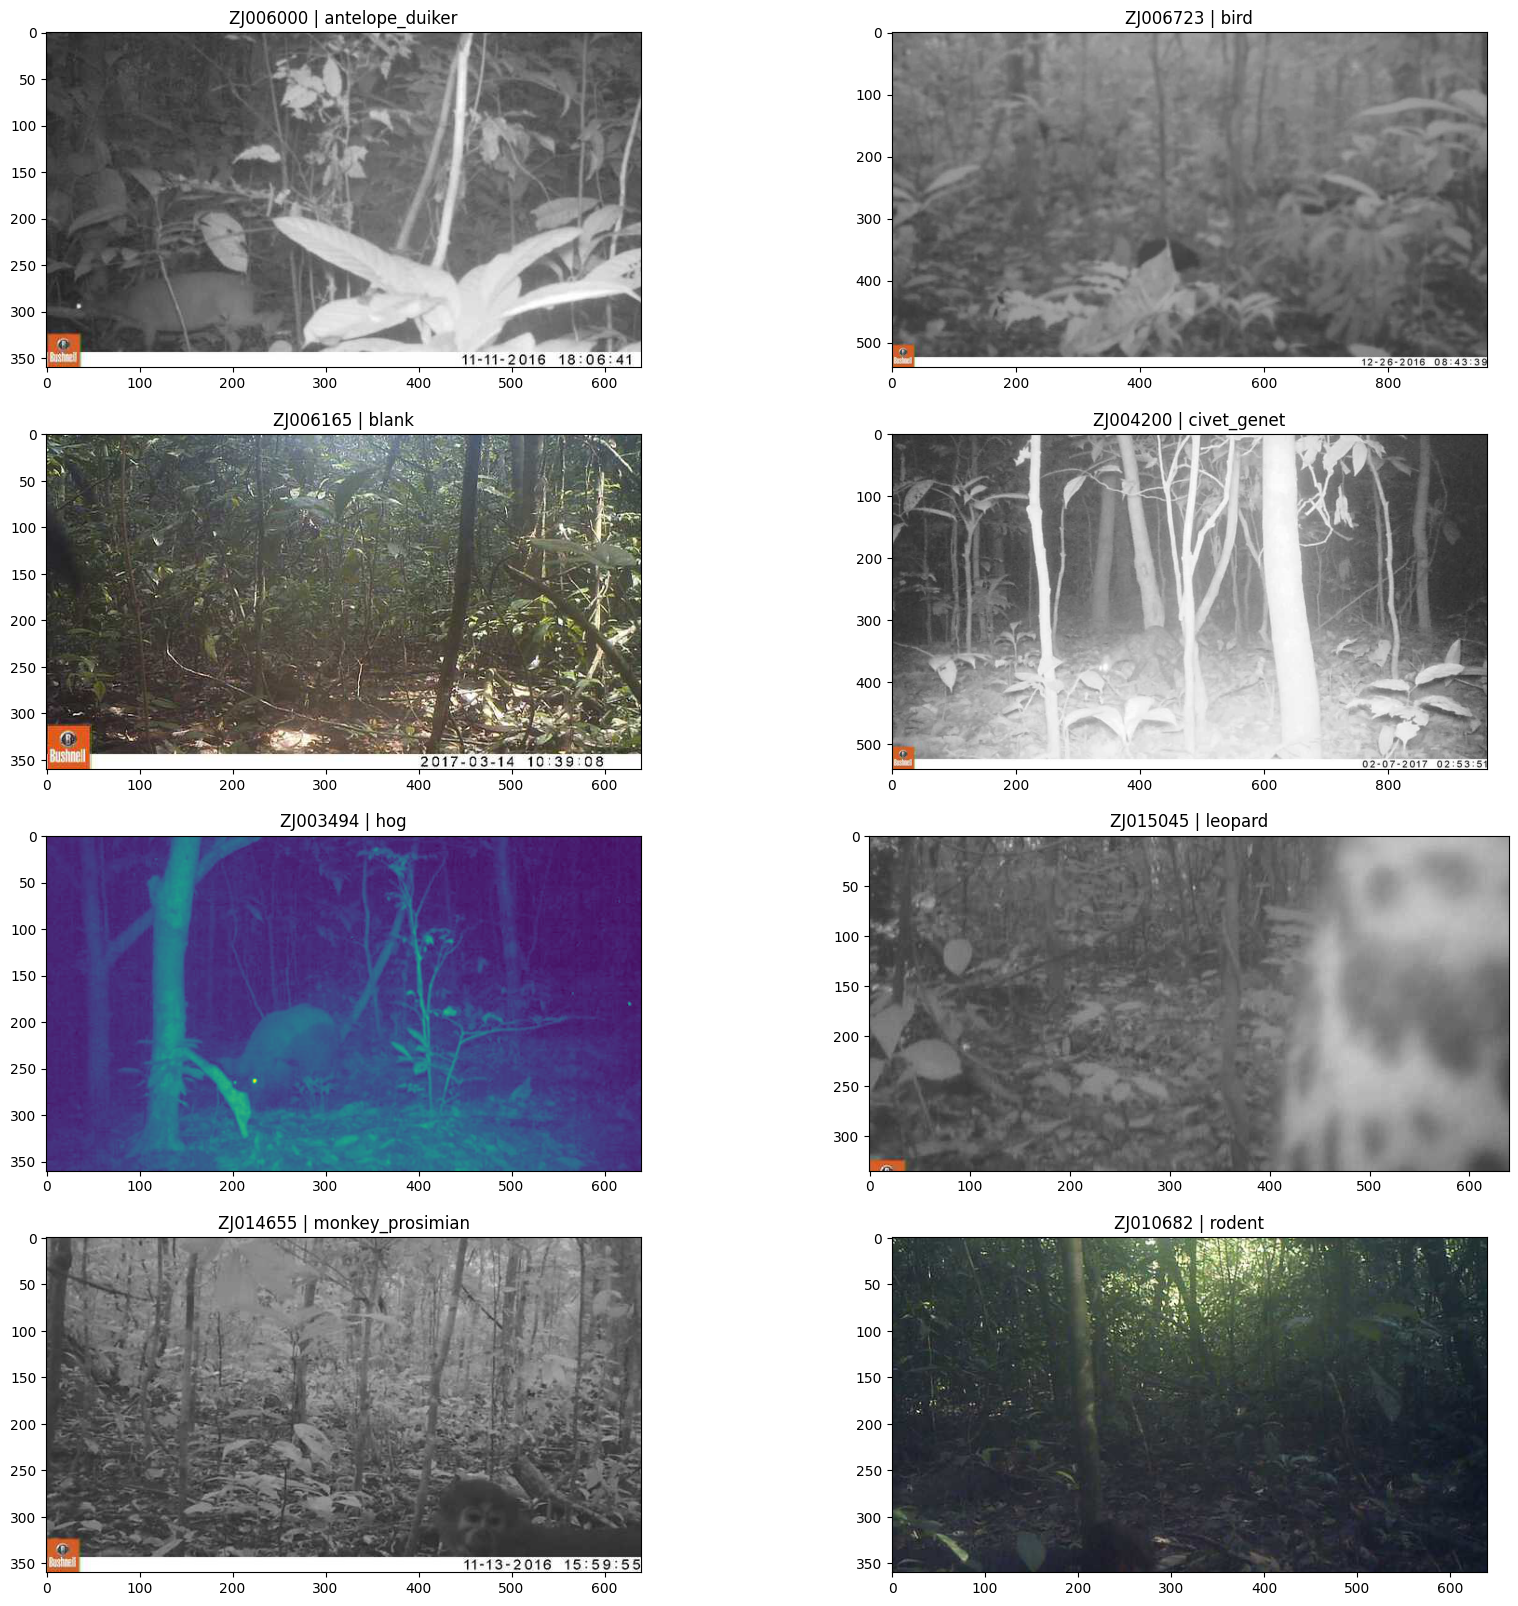

In [ ]:
train_features["id"] = train_features.index

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=SEED)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(f"data/{species}/{train_features.loc[img_id].id}.jpg")
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

train_features = train_features.drop(columns=["id"])

## **How are the images distributed between animal (and blank) categories?**

In [ ]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [ ]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

## **How are the images distributed across camera trap sites?**

In [ ]:
# How many different camera trap sites are there?
train_features["site"].nunique()

148

In [ ]:
# As seen by the output of the 2 cells below, the distribution is uneven between camera trap sites.
train_features["site"].value_counts()

S0060    1132
S0009     664
S0063     557
S0008     541
S0036     456
         ... 
S0143       3
S0078       2
S0079       2
S0178       2
S0102       1
Name: site, Length: 148, dtype: int64

In [ ]:
train_features["site"].value_counts(normalize=True)

S0060    0.068656
S0009    0.040272
S0063    0.033782
S0008    0.032812
S0036    0.027656
           ...   
S0143    0.000182
S0078    0.000121
S0079    0.000121
S0178    0.000121
S0102    0.000061
Name: site, Length: 148, dtype: float64

## **How are animal sightings distributed between camera trap sites?**

In [ ]:
# Obtain camera trap sites with more than 1% participation in the training features
site_vc = train_features["site"].value_counts(normalize=True)
more_than_1_pct_sites = list(site_vc[site_vc > 0.01].index)
print(more_than_1_pct_sites)

['S0060', 'S0009', 'S0063', 'S0008', 'S0036', 'S0043', 'S0059', 'S0038', 'S0120', 'S0062', 'S0141', 'S0014', 'S0071', 'S0022', 'S0136', 'S0020', 'S0101', 'S0023', 'S0069', 'S0031', 'S0186', 'S0030', 'S0049', 'S0184', 'S0070', 'S0053', 'S0074', 'S0002', 'S0083']


In [ ]:
copy_of_train_features = train_features.copy()
copy_of_train_labels = train_labels.copy()

# Apply a function to reduce cardinality of "site"
copy_of_train_features["site"] = copy_of_train_features["site"].apply(lambda site: site if site in more_than_1_pct_sites else "OTHER")

features_labels_join = pd.merge(
    copy_of_train_features,
    copy_of_train_labels,
    on="id",
    how="inner"
)

features_labels_join.sample(5)

,filepath,site,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,,,
ZJ016110,train_features/ZJ016110.jpg,OTHER,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ001040,train_features/ZJ001040.jpg,S0060,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ012349,train_features/ZJ012349.jpg,S0120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ011118,train_features/ZJ011118.jpg,S0009,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ZJ008962,train_features/ZJ008962.jpg,OTHER,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<Axes: ylabel='site'>

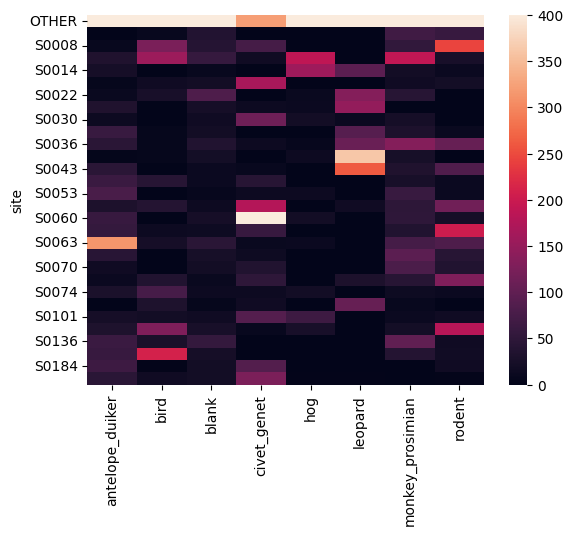

In [ ]:
site_gb = features_labels_join.groupby(by="site")
sns.heatmap(
    site_gb[["antelope_duiker", "bird", "blank", "civet_genet", "hog", "leopard", "monkey_prosimian", "rodent"]].sum(),
    vmin=0,
    vmax=400
)

---
# **Testing the first model**

In [ ]:
model = keras.Sequential()

# Add convolution layer
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

# Add convolution layer
model.add(keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.2))

# Add flattening layer
model.add(keras.layers.Flatten())

# Add Dense layer
model.add(keras.layers.Dense(64, activation="softmax"))
model.add(keras.layers.Dropout(0.2))

# Add Dense Output Layer
model.add(keras.layers.Dense(1, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 16)        0

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
m = model.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/25
207/207 [==============================] - 38s 133ms/step - loss: 0.0000e+00 - accuracy: 0.1010 - val_loss: 0.0000e+00 - val_accuracy: 0.0937
Epoch 2/25
207/207 [==============================] - 11s 54ms/step - loss: 0.0000e+00 - accuracy: 0.1010 - val_loss: 0.0000e+00 - val_accuracy: 0.0937
Epoch 3/25
206/207 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1010

KeyboardInterrupt: ignored

---
# **Testing the second model**

In [ ]:
model2 = keras.Sequential()

# Add the convolutional layers
model2.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model2.add(keras.layers.MaxPooling2D((2, 2)))
model2.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2, 2)))
model2.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten the feature maps
model2.add(keras.layers.Flatten())

# Add the fully connected layers
model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(keras.layers.Dense(1, activation='softmax'))  # 8 animal classes

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
m2 = model2.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/25
207/207 [==============================] - 14s 53ms/step - loss: 0.0000e+00 - accuracy: 0.1010 - val_loss: 0.0000e+00 - val_accuracy: 0.0937
Epoch 2/25
207/207 [==============================] - 11s 51ms/step - loss: 0.0000e+00 - accuracy: 0.1010 - val_loss: 0.0000e+00 - val_accuracy: 0.0937
Epoch 3/25
 59/207 [=======>......................] - ETA: 6s - loss: 0.0000e+00 - accuracy: 0.1046

KeyboardInterrupt: ignored

---
# **Testing models with Resnet18 architecture**

## **First iteration**

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = keras.layers.add([x, inputs])
        x = ReLU()(x)
        return x

class ResidualBlock2(keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock2, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = BatchNormalization()
        self.conv3 = Conv2D(filters, (1, 1), padding='same')
        self.bn3 = BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        parallel = self.conv3(inputs)
        parallel = self.bn3(parallel)
        x = keras.layers.add([x, parallel])
        x = ReLU()(x)
        return x

In [ ]:
resnet18 = keras.Sequential()

# Add Convolution layer
resnet18.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# Batch Normalization
resnet18.add(BatchNormalization())
# ReLU Activation
resnet18.add(Activation("relu"))
# Max Pooling
resnet18.add(MaxPooling2D((3, 3), strides=(2, 2), padding="same"))

# Residual Block 2A
resnet18.add(ResidualBlock(64, (3, 3)))
resnet18.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
resnet18.add(Activation("relu"))

# Residual Block 2B
resnet18.add(ResidualBlock(64, (3, 3)))
resnet18.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
resnet18.add(Activation("relu"))

# Residual Block 3A
resnet18.add(ResidualBlock2(128, (3, 3)))
resnet18.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
resnet18.add(Conv2D(128, (1, 1), strides=(2, 2), padding="same"))
resnet18.add(Activation("relu"))

# Residual Block 3B
resnet18.add(ResidualBlock(128, (3, 3)))
resnet18.add(Conv2D(128, (3, 3), strides=(1, 1), padding="same"))
resnet18.add(Activation("relu"))

# Residual Block 4A
resnet18.add(ResidualBlock2(256, (3, 3)))
resnet18.add(Conv2D(256, (3, 3), strides=(2, 2), padding="same"))
resnet18.add(Conv2D(256, (1, 1), strides=(2, 2), padding="same"))
resnet18.add(Activation("relu"))

# Residual Block 4B
resnet18.add(ResidualBlock(256, (3, 3)))
resnet18.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same"))
resnet18.add(Activation("relu"))

# Residual Block 5A
resnet18.add(ResidualBlock2(512, (3, 3)))
resnet18.add(Conv2D(512, (3, 3), strides=(2, 2), padding="same"))
resnet18.add(Conv2D(512, (1, 1), strides=(2, 2), padding="same"))
resnet18.add(Activation("relu"))

# Residual Block 5B
resnet18.add(ResidualBlock(512, (3, 3)))
resnet18.add(Conv2D(512, (3, 3), strides=(1, 1), padding="same"))
resnet18.add(Activation("relu"))

# Average Pooling
resnet18.add(AveragePooling2D((7, 7), strides=(7, 7), padding="same"))

# Dense Layer
resnet18.add(Dense(2))

# Softmax Classifier
resnet18.add(Dense(1, activation="softmax"))

resnet18.compile(optimizer=keras.optimizers.SGD(learning_rate=1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
r = resnet18.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/25
207/207 [==============================] - 28s 98ms/step - loss: nan - accuracy: 0.1512 - val_loss: nan - val_accuracy: 0.1453
Epoch 2/25
207/207 [==============================] - 20s 95ms/step - loss: nan - accuracy: 0.1512 - val_loss: nan - val_accuracy: 0.1453
Epoch 3/25
207/207 [==============================] - 20s 95ms/step - loss: nan - accuracy: 0.1512 - val_loss: nan - val_accuracy: 0.1453
Epoch 4/25
207/207 [==============================] - 20s 96ms/step - loss: nan - accuracy: 0.1512 - val_loss: nan - val_accuracy: 0.1453
Epoch 5/25
207/207 [==============================] - 20s 96ms/step - loss: nan - accuracy: 0.1512 - val_loss: nan - val_accuracy: 0.1453
Epoch 6/25
207/207 [==============================] - 20s 97ms/step - loss: nan - accuracy: 0.1512 - val_loss: nan - val_accuracy: 0.1453
Epoch 7/25
207/207 [==============================] - 20s 96ms/step - loss: nan - accuracy: 0.1512 - val_loss: nan - val_accuracy: 0.1453
Epoch 8/25
207/207 [==============

## **Second iteration**

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = keras.layers.add([x, inputs])
        x = ReLU()(x)
        return x

class ResidualBlock2(keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock2, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = BatchNormalization()
        self.conv3 = Conv2D(filters, (1, 1), padding='same')
        self.bn3 = BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        parallel = self.conv3(inputs)
        parallel = self.bn3(parallel)
        x = keras.layers.add([x, parallel])
        x = ReLU()(x)
        return x

In [ ]:
resnet18_2 = keras.Sequential()

# Add Convolution layer
resnet18_2.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# Batch Normalization
resnet18_2.add(BatchNormalization())
# ReLU Activation
resnet18_2.add(Activation("relu"))
# Max Pooling
resnet18_2.add(MaxPooling2D((3, 3), strides=(2, 2), padding="same"))

# Residual Block 2A
resnet18_2.add(ResidualBlock(64, (3, 3)))
resnet18_2.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
resnet18_2.add(Activation("relu"))

# Residual Block 2B
resnet18_2.add(ResidualBlock(64, (3, 3)))
resnet18_2.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
resnet18_2.add(Activation("relu"))

# Average Pooling
resnet18_2.add(AveragePooling2D((5, 5), strides=(5, 5), padding="same"))

# Dense Layer
resnet18_2.add(Dense(64))

# Softmax Classifier
resnet18_2.add(Dense(8, activation="softmax"))

resnet18_2.compile(optimizer=keras.optimizers.SGD(learning_rate=1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet18_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 112, 112, 64)      1792      
                                                                 
 batch_normalization_20 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_block_8 (ResidualB  (None, 56, 56, 64)       74368     
 lock)                                                           
                                                      

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
r2 = resnet18_2.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/25


InvalidArgumentError: ignored

---
# **Transfer Learning: Using the pre-built Resnet50 model**

## **First iteration**

In [ ]:
resnet50 = keras.applications.resnet50.ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = keras.Sequential()
model.add(resnet50)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation="softmax"))

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_23 (Dense)            (None, 100)               10035300  
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_24 (Dense)            (None, 8)                 808       
                                                                 
Total params: 33,623,820
Trainable params: 10,036,108
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
r50 = model.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/25
207/207 [==============================] - 32s 135ms/step - loss: 81.8059 - accuracy: 0.1498 - val_loss: 2.0299 - val_accuracy: 0.1535
Epoch 2/25
207/207 [==============================] - 17s 83ms/step - loss: 2.0243 - accuracy: 0.1678 - val_loss: 1.9936 - val_accuracy: 0.1735
Epoch 3/25
207/207 [==============================] - 17s 83ms/step - loss: 1.9866 - accuracy: 0.1892 - val_loss: 1.9606 - val_accuracy: 0.1905
Epoch 4/25
207/207 [==============================] - 17s 83ms/step - loss: 1.9814 - accuracy: 0.1857 - val_loss: 1.8971 - val_accuracy: 0.2184
Epoch 5/25
207/207 [==============================] - 17s 82ms/step - loss: 2.4123 - accuracy: 0.1624 - val_loss: 2.0438 - val_accuracy: 0.1462
Epoch 6/25
207/207 [==============================] - 17s 82ms/step - loss: 2.0469 - accuracy: 0.1496 - val_loss: 2.0425 - val_accuracy: 0.1462
Epoch 7/25
207/207 [==============================] - 17s 84ms/step - loss: 2.0487 - accuracy: 0.1484 - val_loss: 2.0424 - val_accurac

## **Second iteration**

In [ ]:
resnet50 = keras.applications.resnet50.ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = keras.Sequential()
model.add(resnet50)

model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation="softmax"))

for layer in model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 100)               10035300  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 808       
                                                                 
Total params: 33,623,820
Trainable params: 33,570,700
Non-trainable params: 53,120
________________________________________

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
r50_2 = model.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])

Epoch 10/25
207/207 [==============================] - 43s 207ms/step - loss: 0.9688 - accuracy: 0.6393 - val_loss: 1.2841 - val_accuracy: 0.5635
Epoch 11/25
207/207 [==============================] - 43s 207ms/step - loss: 0.9079 - accuracy: 0.6608 - val_loss: 1.2330 - val_accuracy: 0.6051
Epoch 12/25
207/207 [==============================] - 43s 208ms/step - loss: 0.8544 - accuracy: 0.6837 - val_loss: 0.9988 - val_accuracy: 0.6606
Epoch 13/25
207/207 [==============================] - 43s 208ms/step - loss: 0.8004 - accuracy: 0.7064 - val_loss: 1.0163 - val_accuracy: 0.6500
Epoch 14/25
207/207 [==============================] - 43s 207ms/step - loss: 0.7553 - accuracy: 0.7194 - val_loss: 1.0149 - val_accuracy: 0.6727
Epoch 15/25
207/207 [==============================] - 43s 207ms/step - loss: 0.7164 - accuracy: 0.7384 - val_loss: 1.4015 - val_accuracy: 0.5414
Epoch 16/25
207/207 [==============================] - 43s 208ms/step - loss: 0.6875 - accuracy: 0.7526 - val_loss: 1.0471 -

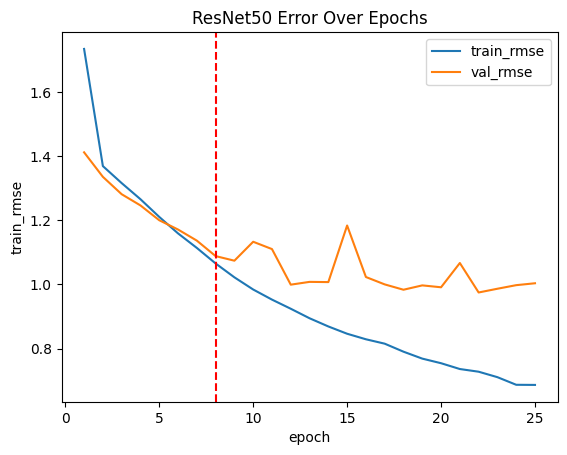

In [ ]:
loss = pd.DataFrame(r50_2.history)
loss["epoch"] = loss.index + 1
loss["train_rmse"] = np.sqrt(loss["loss"])
loss["val_rmse"] = np.sqrt(loss["val_loss"])
fig = sns.lineplot(data=loss, x = "epoch", y = "train_rmse", label = "train_rmse")
fig = sns.lineplot(data=loss, x = "epoch", y = "val_rmse", label = "val_rmse")

plt.title("ResNet50 Error Over Epochs")
plt.axvline(8, linestyle="--", color="red");

#plt.savefig("/content/drive/MyDrive/Data/Wildlife Image Classification/models/ResNet50_2/loss_func_graph")

In [ ]:
# model.save("/content/drive/MyDrive/Data/Wildlife Image Classification/models/ResNet50_2/r50_2.h5")

---
# **Hyperparameter tuning using Optuna**

In [ ]:
# Define an objective function to be minimized.
def objective(trial):

    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    BATCH_SIZE = 64
    EPOCH = 100
    SEED = 42

    # For keras models: first, second, and Resnet18
    train, validation = keras.utils.image_dataset_from_directory(
        "data",
        labels="inferred",
        validation_split = 0.2,
        subset="both",
        seed=42,
        batch_size=BATCH_SIZE
    )

    # Scale and pad to make image dimensions uniform
    def preprocess_image(image, target_height, target_width):
        resized_image = tf.image.resize_with_pad(image, target_height, target_width)
        return resized_image

    preprocessed_train = train.map(lambda image, label: (preprocess_image(image, IMG_HEIGHT, IMG_WIDTH), label))
    preprocessed_validation = validation.map(lambda image, label: (preprocess_image(image, IMG_HEIGHT, IMG_WIDTH), label))

    # Pre-fetch
    AUTOTUNE = tf.data.AUTOTUNE
    preprocessed_train = preprocessed_train.prefetch(buffer_size=AUTOTUNE).cache()
    preprocessed_validation = preprocessed_validation.prefetch(buffer_size=AUTOTUNE).cache()

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    resnet50 = keras.applications.resnet50.ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    model = keras.Sequential()
    model.add(resnet50)

    model.add(Flatten())

    dense_layer_1 = trial.suggest_int("dense_layer_1", 64, 257)
    model.add(Dense(dense_layer_1, activation="relu"))

    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.51)
    model.add(Dropout(dropout_rate))

    model.add(Dense(8, activation="softmax"))

    layers_to_unfreeze = trial.suggest_int("layers_to_unfreeze", -51, -10)
    for layer in model.layers[:layers_to_unfreeze]:
        layer.trainable = False

    optimizer = trial.suggest_categorical("optimizer", ["SGD", "ADAM"])
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1)

    early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    if optimizer == "SGD":
      model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    if optimizer == "ADAM":
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])

    loss, acc = model.evaluate(preprocessed_validation)

    return acc  # An objective value linked with the Trial object.

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

study = optuna.create_study(
    storage="sqlite:///drive/MyDrive/Data/Wildlife_Image_Classification/wildlife_image_classification.db",
    study_name="resnet_onecycle_sgd",
    direction="maximize",
    load_if_exists=True
)  # Create a new study.

study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

[I 2023-06-19 17:13:01,762] Using an existing study with name 'resnet_onecycle_sgd' instead of creating a new one.


Using an existing study with name 'resnet_onecycle_sgd' instead of creating a new one.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/100
207/207 [==============================] - 79s 234ms/step - loss: 4.3596 - accuracy: 0.1653 - val_loss: 2.0342 - val_accuracy: 0.1862
Epoch 2/100
207/207 [==============================] - 43s 209ms/step - loss: 1.9775 - accuracy: 0.2015 - val_loss: 1.9578 - val_accuracy: 0.2123
Epoch 3/100
207/207 [==============================] - 43s 209ms/step - loss: 1.8956 - accuracy: 0.2480 - val_loss: 1.8525 - val_accuracy: 0.2742
Epoch 4/100
207/207 [==============================] - 43s 209ms/step - loss: 1.7678 - accuracy: 0.3095 - val_loss: 1.7109 - val_accuracy: 0.3379
Epoch 5/100
207/207 [==============================] - 43s 208ms/step - loss: 1.6254 - accuracy: 0.3639 - val_loss: 1.7636 - val_accuracy: 0.3615
Epoch 6/100

[I 2023-06-19 17:29:45,267] Trial 85 finished with value: 0.6242038011550903 and parameters: {'dense_layer_1': 189, 'dropout_rate': 0.14086845412309584, 'layers_to_unfreeze': -39, 'learning_rate': 0.09170588025159679, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 85 finished with value: 0.6242038011550903 and parameters: {'dense_layer_1': 189, 'dropout_rate': 0.14086845412309584, 'layers_to_unfreeze': -39, 'learning_rate': 0.09170588025159679, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 63s 228ms/step - loss: 1.0304 - accuracy: 0.6698 - val_loss: 0.9717 - val_accuracy: 0.6442
Epoch 2/100
207/207 [==============================] - 43s 209ms/step - loss: 0.2712 - accuracy: 0.9151 - val_loss: 0.5970 - val_accuracy: 0.7868
Epoch 3/100
207/207 [==============================] - 43s 208ms/step - loss: 0.0911 - accuracy: 0.9816 - val_loss: 0.6464 - val_accuracy: 0.7756
Epoch 4/100
207/207 [==============================] - 43s 209ms/step - loss: 0.0426 - accuracy: 0.9940 - val_loss: 0.5301 - val_accuracy: 0.8241
Epoch 5/100
207/207 [============================

[I 2023-06-19 17:40:40,026] Trial 86 finished with value: 0.8622990846633911 and parameters: {'dense_layer_1': 203, 'dropout_rate': 0.11794256264512708, 'layers_to_unfreeze': -24, 'learning_rate': 0.0028566569804921553, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 86 finished with value: 0.8622990846633911 and parameters: {'dense_layer_1': 203, 'dropout_rate': 0.11794256264512708, 'layers_to_unfreeze': -24, 'learning_rate': 0.0028566569804921553, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 86s 228ms/step - loss: 20.9919 - accuracy: 0.1537 - val_loss: 9695.7188 - val_accuracy: 0.1153
Epoch 2/100
207/207 [==============================] - 44s 211ms/step - loss: 2.0652 - accuracy: 0.1452 - val_loss: 2.0635 - val_accuracy: 0.1507
Epoch 3/100
207/207 [==============================] - 44s 211ms/step - loss: 2.1038 - accuracy: 0.1497 - val_loss: 2.0499 - val_accuracy: 0.1456
Epoch 4/100
207/207 [==============================] - 44s 211ms/step - loss: 2.0612 - accuracy: 0.1472 - val_loss: 2.0482 - val_accuracy: 0.1462
Epoch 5/100
207/207 [======================

[I 2023-06-19 17:50:46,678] Trial 87 finished with value: 0.1461935043334961 and parameters: {'dense_layer_1': 196, 'dropout_rate': 0.12283735636835988, 'layers_to_unfreeze': -23, 'learning_rate': 0.0593828343526983, 'optimizer': 'ADAM'}. Best is trial 54 with value: 0.8756445050239563.


Trial 87 finished with value: 0.1461935043334961 and parameters: {'dense_layer_1': 196, 'dropout_rate': 0.12283735636835988, 'layers_to_unfreeze': -23, 'learning_rate': 0.0593828343526983, 'optimizer': 'ADAM'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 63s 230ms/step - loss: 1.7872 - accuracy: 0.4407 - val_loss: 1.6928 - val_accuracy: 0.3834
Epoch 2/100
207/207 [==============================] - 43s 209ms/step - loss: 0.9258 - accuracy: 0.6625 - val_loss: 0.9319 - val_accuracy: 0.6788
Epoch 3/100
207/207 [==============================] - 43s 209ms/step - loss: 0.6256 - accuracy: 0.7726 - val_loss: 0.8339 - val_accuracy: 0.7270
Epoch 4/100
207/207 [==============================] - 43s 209ms/step - loss: 0.4481 - accuracy: 0.8409 - val_loss: 0.7065 - val_accuracy: 0.7561
Epoch 5/100
207/207 [============================

[I 2023-06-19 17:59:49,708] Trial 88 finished with value: 0.7952684164047241 and parameters: {'dense_layer_1': 203, 'dropout_rate': 0.11545317911491851, 'layers_to_unfreeze': -25, 'learning_rate': 0.02577599188873378, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 88 finished with value: 0.7952684164047241 and parameters: {'dense_layer_1': 203, 'dropout_rate': 0.11545317911491851, 'layers_to_unfreeze': -25, 'learning_rate': 0.02577599188873378, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 62s 224ms/step - loss: 1.0170 - accuracy: 0.6619 - val_loss: 1.1031 - val_accuracy: 0.6409
Epoch 2/100
207/207 [==============================] - 43s 209ms/step - loss: 0.2649 - accuracy: 0.9185 - val_loss: 0.5003 - val_accuracy: 0.8311
Epoch 3/100
207/207 [==============================] - 43s 209ms/step - loss: 0.0957 - accuracy: 0.9822 - val_loss: 0.4818 - val_accuracy: 0.8396
Epoch 4/100
207/207 [==============================] - 43s 208ms/step - loss: 0.0484 - accuracy: 0.9937 - val_loss: 0.4860 - val_accuracy: 0.8514
Epoch 5/100
207/207 [============================

[I 2023-06-19 18:08:13,082] Trial 89 finished with value: 0.8550196886062622 and parameters: {'dense_layer_1': 209, 'dropout_rate': 0.13164099560895848, 'layers_to_unfreeze': -28, 'learning_rate': 0.0018474939680922006, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 89 finished with value: 0.8550196886062622 and parameters: {'dense_layer_1': 209, 'dropout_rate': 0.13164099560895848, 'layers_to_unfreeze': -28, 'learning_rate': 0.0018474939680922006, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 65s 228ms/step - loss: 0.9999 - accuracy: 0.6644 - val_loss: 1.7769 - val_accuracy: 0.3958
Epoch 2/100
207/207 [==============================] - 43s 209ms/step - loss: 0.2702 - accuracy: 0.9168 - val_loss: 0.9654 - val_accuracy: 0.6406
Epoch 3/100
207/207 [==============================] - 43s 210ms/step - loss: 0.0952 - accuracy: 0.9802 - val_loss: 0.8485 - val_accuracy: 0.6979
Epoch 4/100
207/207 [==============================] - 43s 208ms/step - loss: 0.0455 - accuracy: 0.9941 - val_loss: 0.9337 - val_accuracy: 0.6812
Epoch 5/100
207/207 [==========================

[I 2023-06-19 18:27:55,066] Trial 90 finished with value: 0.8586593866348267 and parameters: {'dense_layer_1': 210, 'dropout_rate': 0.13307284685282061, 'layers_to_unfreeze': -28, 'learning_rate': 0.002257206530090843, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 90 finished with value: 0.8586593866348267 and parameters: {'dense_layer_1': 210, 'dropout_rate': 0.13307284685282061, 'layers_to_unfreeze': -28, 'learning_rate': 0.002257206530090843, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 63s 228ms/step - loss: 2.3425 - accuracy: 0.3601 - val_loss: 1.5761 - val_accuracy: 0.4271
Epoch 2/100
207/207 [==============================] - 43s 209ms/step - loss: 1.2181 - accuracy: 0.5496 - val_loss: 1.2379 - val_accuracy: 0.5338
Epoch 3/100
207/207 [==============================] - 43s 209ms/step - loss: 0.9199 - accuracy: 0.6719 - val_loss: 0.9240 - val_accuracy: 0.6576
Epoch 4/100
207/207 [==============================] - 43s 209ms/step - loss: 0.7061 - accuracy: 0.7485 - val_loss: 0.8222 - val_accuracy: 0.7009
Epoch 5/100
207/207 [===========================

[I 2023-06-19 18:39:52,365] Trial 91 finished with value: 0.814376711845398 and parameters: {'dense_layer_1': 210, 'dropout_rate': 0.12663939067576696, 'layers_to_unfreeze': -28, 'learning_rate': 0.029984631201420933, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 91 finished with value: 0.814376711845398 and parameters: {'dense_layer_1': 210, 'dropout_rate': 0.12663939067576696, 'layers_to_unfreeze': -28, 'learning_rate': 0.029984631201420933, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 62s 224ms/step - loss: 2.9321 - accuracy: 0.1697 - val_loss: 2.0232 - val_accuracy: 0.2266
Epoch 2/100
207/207 [==============================] - 43s 210ms/step - loss: 1.9314 - accuracy: 0.2386 - val_loss: 1.8723 - val_accuracy: 0.3048
Epoch 3/100
207/207 [==============================] - 43s 210ms/step - loss: 1.7115 - accuracy: 0.3616 - val_loss: 1.6601 - val_accuracy: 0.3949
Epoch 4/100
207/207 [==============================] - 43s 210ms/step - loss: 1.4611 - accuracy: 0.4558 - val_loss: 1.4338 - val_accuracy: 0.4735
Epoch 5/100
207/207 [============================

[I 2023-06-19 18:53:14,532] Trial 92 finished with value: 0.7270245552062988 and parameters: {'dense_layer_1': 206, 'dropout_rate': 0.10316312906883496, 'layers_to_unfreeze': -19, 'learning_rate': 0.06404822507663194, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 92 finished with value: 0.7270245552062988 and parameters: {'dense_layer_1': 206, 'dropout_rate': 0.10316312906883496, 'layers_to_unfreeze': -19, 'learning_rate': 0.06404822507663194, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 64s 228ms/step - loss: 5.1061 - accuracy: 0.1763 - val_loss: 2.2206 - val_accuracy: 0.1708
Epoch 2/100
207/207 [==============================] - 43s 210ms/step - loss: 2.0064 - accuracy: 0.2104 - val_loss: 2.0115 - val_accuracy: 0.1956
Epoch 3/100
207/207 [==============================] - 43s 209ms/step - loss: 1.9132 - accuracy: 0.2515 - val_loss: 2.0699 - val_accuracy: 0.1553
Epoch 4/100
207/207 [==============================] - 43s 209ms/step - loss: 1.7961 - accuracy: 0.2955 - val_loss: 2.1557 - val_accuracy: 0.1850
Epoch 5/100
207/207 [============================

[I 2023-06-19 19:17:51,314] Trial 93 finished with value: 0.6651501655578613 and parameters: {'dense_layer_1': 196, 'dropout_rate': 0.11523409932989899, 'layers_to_unfreeze': -25, 'learning_rate': 0.08743105813194071, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 93 finished with value: 0.6651501655578613 and parameters: {'dense_layer_1': 196, 'dropout_rate': 0.11523409932989899, 'layers_to_unfreeze': -25, 'learning_rate': 0.08743105813194071, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 64s 229ms/step - loss: 1.0319 - accuracy: 0.6562 - val_loss: 1.6468 - val_accuracy: 0.4307
Epoch 2/100
207/207 [==============================] - 43s 210ms/step - loss: 0.2858 - accuracy: 0.9137 - val_loss: 0.5981 - val_accuracy: 0.7925
Epoch 3/100
207/207 [==============================] - 43s 208ms/step - loss: 0.1078 - accuracy: 0.9779 - val_loss: 0.7866 - val_accuracy: 0.7188
Epoch 4/100
207/207 [==============================] - 43s 208ms/step - loss: 0.0530 - accuracy: 0.9933 - val_loss: 0.6870 - val_accuracy: 0.7692
Epoch 5/100
207/207 [============================

[I 2023-06-19 19:31:53,087] Trial 94 finished with value: 0.8616924285888672 and parameters: {'dense_layer_1': 213, 'dropout_rate': 0.135247671417699, 'layers_to_unfreeze': -23, 'learning_rate': 0.0017960959231114342, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 94 finished with value: 0.8616924285888672 and parameters: {'dense_layer_1': 213, 'dropout_rate': 0.135247671417699, 'layers_to_unfreeze': -23, 'learning_rate': 0.0017960959231114342, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 64s 226ms/step - loss: 2.5724 - accuracy: 0.3218 - val_loss: 10.4356 - val_accuracy: 0.3403
Epoch 2/100
207/207 [==============================] - 44s 210ms/step - loss: 1.3308 - accuracy: 0.5100 - val_loss: 2.7640 - val_accuracy: 0.3379
Epoch 3/100
207/207 [==============================] - 44s 210ms/step - loss: 1.0737 - accuracy: 0.6096 - val_loss: 1.2598 - val_accuracy: 0.5526
Epoch 4/100
207/207 [==============================] - 44s 210ms/step - loss: 0.8410 - accuracy: 0.6945 - val_loss: 0.9401 - val_accuracy: 0.6776
Epoch 5/100
207/207 [===========================

[I 2023-06-19 19:43:07,427] Trial 95 finished with value: 0.761904776096344 and parameters: {'dense_layer_1': 214, 'dropout_rate': 0.1407291617502109, 'layers_to_unfreeze': -24, 'learning_rate': 0.04387958730838226, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 95 finished with value: 0.761904776096344 and parameters: {'dense_layer_1': 214, 'dropout_rate': 0.1407291617502109, 'layers_to_unfreeze': -24, 'learning_rate': 0.04387958730838226, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 65s 226ms/step - loss: 7.8733 - accuracy: 0.2094 - val_loss: 2.0526 - val_accuracy: 0.1453
Epoch 2/100
207/207 [==============================] - 44s 210ms/step - loss: 1.8619 - accuracy: 0.2753 - val_loss: 1.8896 - val_accuracy: 0.2618
Epoch 3/100
207/207 [==============================] - 43s 209ms/step - loss: 1.8066 - accuracy: 0.3053 - val_loss: 1.9580 - val_accuracy: 0.2878
Epoch 4/100
207/207 [==============================] - 43s 210ms/step - loss: 1.7216 - accuracy: 0.3405 - val_loss: 1.8206 - val_accuracy: 0.3348
Epoch 5/100
207/207 [==============================

[I 2023-06-19 20:10:06,628] Trial 96 finished with value: 0.6414922475814819 and parameters: {'dense_layer_1': 224, 'dropout_rate': 0.148313097547042, 'layers_to_unfreeze': -22, 'learning_rate': 0.10683252657419563, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 96 finished with value: 0.6414922475814819 and parameters: {'dense_layer_1': 224, 'dropout_rate': 0.148313097547042, 'layers_to_unfreeze': -22, 'learning_rate': 0.10683252657419563, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 63s 224ms/step - loss: 1.8483 - accuracy: 0.5821 - val_loss: 1.2031 - val_accuracy: 0.5772
Epoch 2/100
207/207 [==============================] - 43s 210ms/step - loss: 0.5434 - accuracy: 0.8103 - val_loss: 0.7186 - val_accuracy: 0.7486
Epoch 3/100
207/207 [==============================] - 43s 210ms/step - loss: 0.2936 - accuracy: 0.9013 - val_loss: 0.6248 - val_accuracy: 0.7919
Epoch 4/100
207/207 [==============================] - 43s 209ms/step - loss: 0.1688 - accuracy: 0.9441 - val_loss: 0.6615 - val_accuracy: 0.7931
Epoch 5/100
207/207 [==============================

[I 2023-06-19 20:19:13,307] Trial 97 finished with value: 0.8477403521537781 and parameters: {'dense_layer_1': 187, 'dropout_rate': 0.16794110353464412, 'layers_to_unfreeze': -26, 'learning_rate': 0.020104664033524518, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 97 finished with value: 0.8477403521537781 and parameters: {'dense_layer_1': 187, 'dropout_rate': 0.16794110353464412, 'layers_to_unfreeze': -26, 'learning_rate': 0.020104664033524518, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 64s 226ms/step - loss: 4.1385 - accuracy: 0.2894 - val_loss: 67.2347 - val_accuracy: 0.1250
Epoch 2/100
207/207 [==============================] - 44s 210ms/step - loss: 1.5602 - accuracy: 0.4038 - val_loss: 1.4567 - val_accuracy: 0.4619
Epoch 3/100
207/207 [==============================] - 43s 210ms/step - loss: 1.3587 - accuracy: 0.4926 - val_loss: 1.3113 - val_accuracy: 0.4977
Epoch 4/100
207/207 [==============================] - 43s 210ms/step - loss: 1.1864 - accuracy: 0.5586 - val_loss: 1.2180 - val_accuracy: 0.5429
Epoch 5/100
207/207 [==========================

[I 2023-06-19 20:31:10,536] Trial 98 finished with value: 0.6596906185150146 and parameters: {'dense_layer_1': 203, 'dropout_rate': 0.10001300012659836, 'layers_to_unfreeze': -29, 'learning_rate': 0.06425099257255916, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 98 finished with value: 0.6596906185150146 and parameters: {'dense_layer_1': 203, 'dropout_rate': 0.10001300012659836, 'layers_to_unfreeze': -29, 'learning_rate': 0.06425099257255916, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 65s 226ms/step - loss: 1.5603 - accuracy: 0.5743 - val_loss: 1.9151 - val_accuracy: 0.6160
Epoch 2/100
207/207 [==============================] - 43s 210ms/step - loss: 0.5732 - accuracy: 0.7989 - val_loss: 0.6140 - val_accuracy: 0.7898
Epoch 3/100
207/207 [==============================] - 43s 210ms/step - loss: 0.3227 - accuracy: 0.8914 - val_loss: 0.5601 - val_accuracy: 0.8071
Epoch 4/100
207/207 [==============================] - 43s 210ms/step - loss: 0.1883 - accuracy: 0.9385 - val_loss: 0.5341 - val_accuracy: 0.8298
Epoch 5/100
207/207 [============================

[I 2023-06-19 20:38:09,276] Trial 99 finished with value: 0.8298453092575073 and parameters: {'dense_layer_1': 216, 'dropout_rate': 0.12949500124999422, 'layers_to_unfreeze': -23, 'learning_rate': 0.017156760142735494, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 99 finished with value: 0.8298453092575073 and parameters: {'dense_layer_1': 216, 'dropout_rate': 0.12949500124999422, 'layers_to_unfreeze': -23, 'learning_rate': 0.017156760142735494, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 62s 224ms/step - loss: 1.0022 - accuracy: 0.6726 - val_loss: 1.0546 - val_accuracy: 0.6281
Epoch 2/100
207/207 [==============================] - 43s 210ms/step - loss: 0.2625 - accuracy: 0.9150 - val_loss: 0.5485 - val_accuracy: 0.8101
Epoch 3/100
207/207 [==============================] - 43s 209ms/step - loss: 0.0797 - accuracy: 0.9794 - val_loss: 0.6104 - val_accuracy: 0.8053
Epoch 4/100
207/207 [==============================] - 43s 210ms/step - loss: 0.0324 - accuracy: 0.9947 - val_loss: 0.4975 - val_accuracy: 0.8520
Epoch 5/100
207/207 [===========================

[I 2023-06-19 20:45:04,236] Trial 100 finished with value: 0.8519866466522217 and parameters: {'dense_layer_1': 208, 'dropout_rate': 0.11619633404996606, 'layers_to_unfreeze': -27, 'learning_rate': 0.00477636742216456, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.


Trial 100 finished with value: 0.8519866466522217 and parameters: {'dense_layer_1': 208, 'dropout_rate': 0.11619633404996606, 'layers_to_unfreeze': -27, 'learning_rate': 0.00477636742216456, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.8756445050239563.
Found 16488 files belonging to 8 classes.
Using 13191 files for training.
Using 3297 files for validation.
Epoch 1/100
207/207 [==============================] - 63s 226ms/step - loss: 2.1176 - accuracy: 0.3861 - val_loss: 1.5557 - val_accuracy: 0.4055
Epoch 2/100
207/207 [==============================] - 44s 211ms/step - loss: 1.1084 - accuracy: 0.5971 - val_loss: 0.9597 - val_accuracy: 0.6548
Epoch 3/100
 67/207 [========>.....................] - ETA: 27s - loss: 0.8786 - accuracy: 0.6826

[W 2023-06-19 20:47:09,101] Trial 101 failed with parameters: {'dense_layer_1': 199, 'dropout_rate': 0.13112175618619762, 'layers_to_unfreeze': -21, 'learning_rate': 0.05197400466759357, 'optimizer': 'SGD'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-4-1064483c948b>", line 63, in objective
    model.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.p

Trial 101 failed with parameters: {'dense_layer_1': 199, 'dropout_rate': 0.13112175618619762, 'layers_to_unfreeze': -21, 'learning_rate': 0.05197400466759357, 'optimizer': 'SGD'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-4-1064483c948b>", line 63, in objective
    model.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handl

[W 2023-06-19 20:47:09,111] Trial 101 failed with value None.


Trial 101 failed with value None.


KeyboardInterrupt: ignored

---
# **Using best model to make predictions**

In [ ]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

study = optuna.create_study(
    storage="sqlite:///drive/MyDrive/Data/Wildlife_Image_Classification/wildlife_image_classification.db",
    study_name="resnet_onecycle_sgd",
    load_if_exists=True
)

[I 2023-06-20 00:10:26,432] Using an existing study with name 'resnet_onecycle_sgd' instead of creating a new one.


Using an existing study with name 'resnet_onecycle_sgd' instead of creating a new one.


In [ ]:
best_params = study.best_params
best_params

{'dense_layer_1': 193,
 'dropout_rate': 0.18151559414215632,
 'layers_to_unfreeze': -35,
 'learning_rate': 0.006748614513541312,
 'optimizer': 'SGD'}

In [ ]:
# Invoke suggest methods of a Trial object to generate hyperparameters.
resnet50 = keras.applications.resnet50.ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = keras.Sequential()
model.add(resnet50)

model.add(Flatten())

model.add(Dense(best_params["dense_layer_1"], activation="relu"))

model.add(Dropout(best_params["dropout_rate"]))

model.add(Dense(8, activation="softmax"))

for layer in model.layers[:best_params["layers_to_unfreeze"]]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.SGD(learning_rate=best_params["learning_rate"]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(preprocessed_train, validation_data=preprocessed_validation, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[early_stopping])

94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/25
207/207 [==============================] - 76s 235ms/step - loss: 1.1638 - accuracy: 0.6557 - val_loss: 1.6022 - val_accuracy: 0.5086
Epoch 2/25
207/207 [==============================] - 43s 208ms/step - loss: 0.3389 - accuracy: 0.8905 - val_loss: 0.5836 - val_accuracy: 0.7965
Epoch 3/25
207/207 [==============================] - 43s 208ms/step - loss: 0.1265 - accuracy: 0.9616 - val_loss: 0.5015 - val_accuracy: 0.8368
Epoch 4/25
207/207 [==============================] - 43s 207ms/step - loss: 0.0515 - accuracy: 0.9875 - val_loss: 0.5272 - val_accuracy: 0.8380
Epoch 5/25
207/207 [==============================] - 43s 207ms/step - loss: 0.0250 - accuracy: 0.9955 - val_loss: 0.5516 - val_accuracy: 0.8371
Epoch 6/25
207/207 [==============================] - 43s 207ms/step - loss: 0.0165 - accuracy: 0.9971 - val_loss: 0.5426 - val_accuracy: 0.8541
Epoch 7/25
207/207 [==============================] - 43s 207ms/s

In [ ]:
predictions = model.predict(preprocessed_test)
predictions

70/70 [==============================] - 4s 63ms/step


array([[4.0812045e-01, 7.6236203e-03, 2.2916931e-01, ..., 1.0946946e-04,
        7.3584057e-02, 2.8089035e-01],
       [4.8458665e-03, 1.5375037e-05, 9.3023872e-01, ..., 5.7037629e-04,
        3.0966621e-05, 5.3509306e-02],
       [9.9325365e-01, 5.3270545e-05, 4.4530248e-03, ..., 6.7206279e-06,
        1.4130619e-03, 2.3996804e-04],
       ...,
       [2.2547665e-01, 1.2557166e-02, 6.5451437e-01, ..., 2.0376171e-04,
        4.2412858e-02, 6.4424440e-02],
       [9.8307937e-02, 8.0065444e-02, 4.6812859e-01, ..., 1.2708925e-02,
        3.1261346e-01, 1.2026757e-02],
       [2.4092957e-02, 7.9656462e-04, 7.0572698e-01, ..., 1.9022690e-01,
        3.0808472e-03, 1.8634878e-02]], dtype=float32)

In [ ]:
predictions_df = pd.DataFrame(predictions, index=test_features.index).reset_index()

columns = ["id"] + sorted(os.listdir("data"))

predictions_df.columns = columns

predictions_df.head(10)

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,4.081205e-01,7.623620e-03,0.229169,2.668057e-04,2.359486e-04,1.094695e-04,7.358406e-02,2.808903e-01
1,ZJ016489,4.845866e-03,1.537504e-05,0.930239,1.074886e-02,4.059446e-05,5.703763e-04,3.096662e-05,5.350931e-02
2,ZJ016490,9.932536e-01,5.327055e-05,0.004453,7.626382e-05,5.041416e-04,6.720628e-06,1.413062e-03,2.399680e-04
3,ZJ016491,6.614856e-01,4.145236e-02,0.174236,3.143276e-04,5.188503e-04,4.822228e-03,1.125322e-01,4.638079e-03
4,ZJ016492,9.854872e-01,3.731381e-05,0.000114,1.878590e-06,1.235523e-05,5.469372e-08,1.433822e-02,8.736491e-06
5,ZJ016493,7.572842e-01,4.216312e-03,0.132288,7.734707e-03,7.880791e-02,1.743542e-03,1.205706e-02,5.868216e-03
6,ZJ016494,1.184819e-01,6.829191e-03,0.054765,3.359764e-05,2.589448e-03,5.867364e-04,8.092713e-01,7.443286e-03
7,ZJ016495,4.545158e-01,8.091615e-04,0.541008,7.388266e-05,2.908823e-04,1.541615e-03,1.226709e-03,5.344545e-04
8,ZJ016496,6.378222e-01,8.497607e-04,0.289157,2.722687e-04,2.982276e-03,5.711541e-04,5.700672e-02,1.133855e-02
9,ZJ016497,6.632004e-09,1.366476e-09,0.000002,1.034217e-12,3.895848e-09,9.999973e-01,9.091982e-11,5.872706e-07


In [ ]:
# Save best model
model.save("drive/MyDrive/Data/Wildlife_Image_Classification/best_model_19_06_2023.h5")

In [ ]:
# Save predictions
predictions_df.to_csv("drive/MyDrive/Data/Wildlife_Image_Classification/predictions_19_06_2023", index=False)

---
# **Results**

In [ ]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

study = optuna.create_study(
    storage="sqlite:///drive/MyDrive/Data/Wildlife_Image_Classification/wildlife_image_classification.db",
    study_name="resnet_onecycle_sgd",
    load_if_exists=True
)

[I 2023-06-20 22:48:41,640] Using an existing study with name 'resnet_onecycle_sgd' instead of creating a new one.


Using an existing study with name 'resnet_onecycle_sgd' instead of creating a new one.


In [ ]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import optuna

# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

np.random.seed(SEED)

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study, params=["dense_layer_1", "dropout_rate"])

In [ ]:
plot_parallel_coordinate(study, params=["learning_rate", "dropout_rate", "dense_layer_1", "layers_to_unfreeze"])

In [ ]:
# Plot confusion matrix of model predictions on validation set

# Load best model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Data/Wildlife_Image_Classification/best_model_19_06_2023.h5')

# Use model to predict labels for validation images
val_predict = best_model.predict(preprocessed_validation)

# Populate a DataFrame with predictions
val_pred_df = pd.DataFrame(val_predict)
val_pred_df

52/52 [==============================] - 643s 12s/step


,0,1,2,3,4,5,6,7
0,9.524828e-01,9.069860e-06,1.603118e-04,1.445520e-06,7.553393e-05,5.402909e-07,4.726265e-02,7.540606e-06
1,5.109429e-03,8.694141e-07,2.936208e-07,7.258132e-09,9.948890e-01,1.264766e-07,1.797331e-07,2.078556e-07
2,1.013521e-02,1.371192e-04,6.744504e-03,9.674351e-01,2.037571e-04,7.922616e-05,2.888172e-04,1.497618e-02
3,6.393844e-07,8.518510e-08,7.584768e-06,1.096086e-09,4.961167e-09,9.999916e-01,5.505967e-08,1.829098e-09
4,4.119141e-01,7.824210e-02,1.433502e-01,2.893276e-02,1.999512e-02,1.344110e-03,2.901106e-01,2.611101e-02
...,...,...,...,...,...,...,...,...
3292,1.698260e-06,4.213652e-06,5.827778e-05,8.310257e-10,9.959342e-07,9.999267e-01,7.522005e-06,5.213604e-07
3293,5.851330e-07,3.120152e-06,1.486641e-04,1.339027e-06,1.538243e-05,9.997888e-01,2.398858e-06,3.972969e-05
3294,7.155607e-02,9.799803e-03,8.532208e-01,1.758581e-03,1.317405e-03,2.931783e-02,3.148184e-02,1.547652e-03
3295,3.816699e-01,2.244934e-02,5.396793e-01,3.984508e-04,7.239669e-04,4.799941e-04,2.236447e-02,3.223465e-02


In [ ]:
# Extracting images and True labels from the preprocessed_validation batch dataset

# Retrieve the labels from the validation dataset
validation_labels = preprocessed_validation.unbatch().map(lambda image, label: label)

# Convert the labels to a NumPy array
validation_labels = np.array(list(validation_labels.as_numpy_iterator()))

# Print the shape of the extracted labels
print(validation_labels.shape)

(3297,)


In [ ]:
# Convert label array to a column of val_pred_df
val_pred_df["true_label"] = validation_labels
val_pred_df.sample(10)

,0,1,2,3,4,5,6,7,true_label
1899,5.946061e-02,8.023215e-01,0.055891,2.923718e-04,1.036353e-03,0.000616,5.292170e-02,2.746035e-02,1
444,1.182727e-02,6.878550e-05,0.029130,9.575859e-01,3.614291e-04,0.000203,9.886162e-05,7.245629e-04,3
1688,7.792242e-01,4.057181e-03,0.083689,2.940066e-02,2.573550e-03,0.001235,5.850289e-02,4.131698e-02,2
1980,2.614712e-02,5.704247e-03,0.059495,8.918669e-01,3.746197e-04,0.002364,2.572455e-03,1.147623e-02,3
2808,7.461072e-03,3.100479e-05,0.002531,9.709465e-01,6.202263e-05,0.000296,5.595620e-05,1.861697e-02,3
1938,2.347241e-01,2.685862e-05,0.749426,8.683109e-04,8.976349e-05,0.000064,1.460075e-02,1.999273e-04,2
2825,1.032366e-08,2.627072e-08,0.000049,8.023222e-12,3.942655e-09,0.999951,6.108062e-10,8.860642e-09,5
34,4.382576e-03,2.180424e-03,0.000440,9.786381e-07,2.520724e-04,0.000031,9.926467e-01,6.603881e-05,6
1075,4.443147e-04,4.830040e-05,0.010927,1.353235e-02,2.107158e-05,0.000421,3.468774e-05,9.745707e-01,7
2541,1.667700e-05,7.590682e-07,0.000268,5.580126e-08,9.994661e-01,0.000247,4.760704e-07,8.975591e-07,4


In [ ]:
# Convert 0-7 to actual label names to improve readability

label_names = {
    0: "antelope_duiker",
    1: "bird",
    2: "blank",
    3: "civet_genet",
    4: "hog",
    5: "leopard",
    6: "monkey_prosimian",
    7: "rodent"
}

val_pred_df = val_pred_df.rename(columns=label_names)
val_pred_df["true_label"] = val_pred_df["true_label"].apply(lambda number: label_names[number])
val_pred_df.sample(10)

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,true_label
522,0.019687,0.000030,0.003216,0.000031,0.000327,4.407655e-05,0.970764,5.901032e-03,monkey_prosimian
2724,0.013078,0.000105,0.150347,0.058822,0.000062,5.724235e-04,0.000799,7.762141e-01,rodent
179,0.308688,0.001446,0.603922,0.002959,0.015320,1.968633e-02,0.000642,4.733719e-02,blank
2009,0.019945,0.001876,0.046980,0.206850,0.017368,1.775035e-02,0.015409,6.738225e-01,rodent
3196,0.002583,0.000017,0.031885,0.963544,0.000236,7.795408e-05,0.000061,1.595967e-03,civet_genet
84,0.000257,0.000010,0.002325,0.997147,0.000007,6.341308e-05,0.000027,1.637239e-04,civet_genet
503,0.896318,0.000217,0.000011,0.000001,0.069931,1.241456e-04,0.033398,2.997031e-07,monkey_prosimian
2346,0.001570,0.000078,0.001120,0.984579,0.000043,6.484178e-05,0.000137,1.240845e-02,civet_genet
1219,0.241431,0.014846,0.065972,0.002476,0.000286,4.502685e-05,0.100051,5.748931e-01,rodent
3205,0.004157,0.000036,0.001386,0.000193,0.000044,5.859929e-07,0.991066,3.116923e-03,monkey_prosimian


In [ ]:
val_pred_df.head(5)

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,true_label
0,9.524828e-01,9.069860e-06,1.603118e-04,1.445520e-06,7.553393e-05,5.402909e-07,4.726265e-02,7.540606e-06,antelope_duiker
1,5.109429e-03,8.694141e-07,2.936208e-07,7.258132e-09,9.948890e-01,1.264766e-07,1.797331e-07,2.078556e-07,hog
2,1.013521e-02,1.371192e-04,6.744504e-03,9.674351e-01,2.037571e-04,7.922616e-05,2.888172e-04,1.497618e-02,civet_genet
3,6.393844e-07,8.518510e-08,7.584768e-06,1.096086e-09,4.961167e-09,9.999916e-01,5.505967e-08,1.829098e-09,leopard
4,4.119141e-01,7.824210e-02,1.433502e-01,2.893276e-02,1.999512e-02,1.344110e-03,2.901106e-01,2.611101e-02,antelope_duiker


In [ ]:
# Extract which label the model feels most confident for each image to create "pred_label" column
max_label = val_pred_df.iloc[:, :].idxmax(axis=1, numeric_only=True)
val_pred_df["pred_label"] = max_label

true_pred_df = val_pred_df[["true_label", "pred_label"]]
true_pred_df.sample(5)

,true_label,pred_label
2319,civet_genet,civet_genet
2557,blank,antelope_duiker
2218,leopard,leopard
2220,leopard,leopard
1830,civet_genet,civet_genet


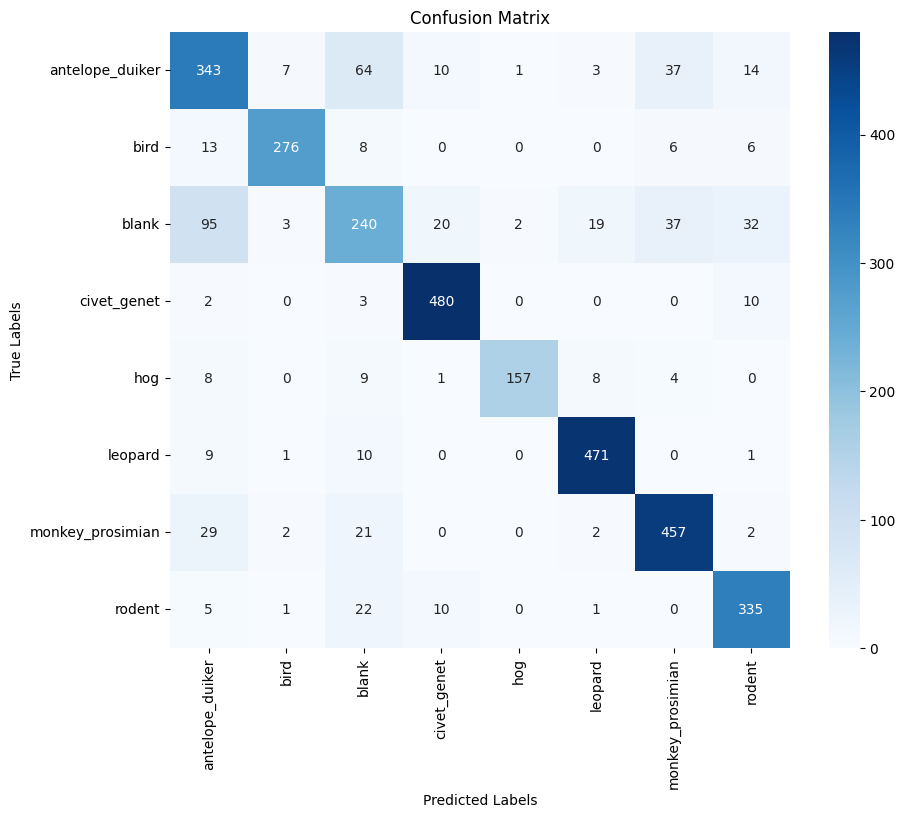

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_pred_df["true_label"], true_pred_df["pred_label"])

# Get unique labels
labels = np.unique(true_pred_df["true_label"])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

---
# **Bibliography:**

- [Michael Schlauch: INTRODUCTION TO IMAGE CLASSIFICATION USING CAMERA TRAP IMAGES - 2022](https://drivendata.co/blog/conservision-benchmark/)
- [Yashvi Chandola, ... Papendra Kumar: End-to-end pre-trained CNN-based computer-aided classification system design for chest radiographs - Deep Learning for Chest Radiographs, 2021](https://www.sciencedirect.com/topics/computer-science/residual-network)
- [Sabyasachi Sahoo: Residual blocks — Building blocks of ResNet - 2018](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)
- [Michael A. Tabak et al: Machine learning to classify animal species in camera trap images: Applications in ecology - 2019](https://besjournals.onlinelibrary.wiley.com/doi/epdf/10.1111/2041-210X.13120)
- [Kaiming He et al: Deep Residual Learning for Image Recognition](https://ieeexplore.ieee.org/document/7780459)
- [Kavish Sanghvi: Fauna Image Classification using Convolutional Neural Network - 2020](https://medium.com/analytics-vidhya/fauna-image-classification-using-convolutional-neural-network-30df9e25a010)
- [Sergios Karagiannakos: How to Use Data Augmentation to 10x Your Image Datasets - 2020](https://towardsdatascience.com/how-to-use-data-augmentation-to-10x-your-image-datasets-dab42858be55)
- [Alexander Buslaev et al - Albumentations: fast and flexible image augmentations: 2018](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1809.06839v1.pdf)
- Training serving skew